In [1]:
!pip install torch torchaudio transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 31.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
!pip install torchviz

In [3]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 24.1 MB/s eta 0:00:00


In [4]:
!pip install torchsummary

In [5]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 33.8 MB/s eta 0:00:00


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Model Components:
Feature Extractor:
_ModuleFeatureExtractor(
  (pipeline): Sequential(
    (0): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
    (1): _FunctionalModule()
    (2): _FunctionalModule()
    (3): _GlobalStatsNormalization()
    (4): _FunctionalModule()
  )
)

Decoder:
RNNTBeamSearch(
  (model): RNNT(
    (transcriber): _EmformerEncoder(
      (input_linear): Linear(in_features=80, out_features=128, bias=False)
      (time_reduction): _TimeReduction()
      (transformer): Emformer(
        (memory_op): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
        (emformer_layers): ModuleList(
          (0-19): 20 x _EmformerLayer(
            (attention): _EmformerAttention(
              (emb_to_key_value): Linear(in_features=512, out_features=1024, bias=True)
              (emb_to_query): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
          

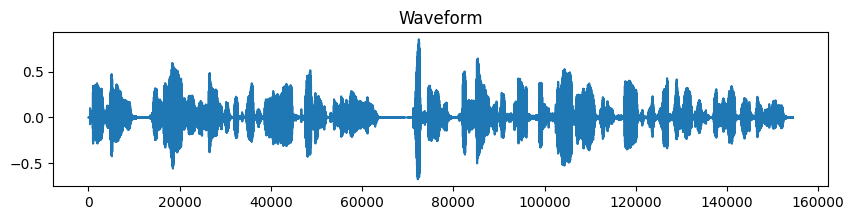

Transcription: printing in the only sense with which we are at present concerned differs from most if not from all the arts and crafts represented in the exhib
Word Error Rate (WER): 0.037037037037037035


In [38]:
import torch
import torchaudio
import matplotlib.pyplot as plt
from torchaudio.pipelines import EMFORMER_RNNT_BASE_LIBRISPEECH
from jiwer import wer

# Load components from the pre-trained Emformer RNN-T pipeline
bundle = EMFORMER_RNNT_BASE_LIBRISPEECH
feature_extractor = bundle.get_feature_extractor()
decoder = bundle.get_decoder()
token_processor = bundle.get_token_processor()
print("Model Components:")
print(f"Feature Extractor:\n{feature_extractor}\n")
print(f"Decoder:\n{decoder}\n")
print(f"Token Processor:\n{token_processor}\n")

# Load the audio file
audio_path = "/content/LJ001-0001.wav"
waveform, sample_rate = torchaudio.load(audio_path)

# Resample to 16kHz
if sample_rate != 16000:
    resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
    waveform = resampler(waveform)

# Plot the waveform
plt.figure(figsize=(10, 2))
plt.plot(waveform[0].numpy())
plt.title("Waveform")
plt.show()

# Emformer expects 1D waveform for a single utterance
waveform = waveform.squeeze(0) if waveform.shape[0] == 1 else waveform

# Extract features
with torch.no_grad():
    features, length = feature_extractor(waveform)

# Decode top-10 hypotheses
hypotheses = decoder(features, length, beam_width=10)

# Process tokens to text
transcription = token_processor(hypotheses[0][0])
print("Transcription:", transcription)

# Evaluate against a reference
reference = "Printing in the only sense with which we are at present concerned differs from most if not from all the arts and crafts represented in the Exhibition"
error = wer(reference.lower(), transcription.lower())
print("Word Error Rate (WER):", error)
